In [ ]:
Landcover tif to dataframe

In [ ]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
%matplotlib inline
# File path to the .tif file
#why does 0.001 not work?
file_path = "/shared_space/ACV/nlcd_nc0.1.tif"

# Open the .tif file
with rasterio.open(file_path) as src:
    # Read a specific band (e.g., the first band)
    band1 = src.read(1)

    # Plot the band
    plt.figure(figsize=(10, 8))
    plt.imshow(band1, cmap="viridis")
    plt.colorbar(label="Value")
    plt.title("Land Cover Map - Band 1")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

In [3]:
import geopandas as gpd
import rasterio as rs
# Load the elevation data (GeoTIFF)
land_file = '/shared_space/ACV/nlcd_nc0.1.tif'
with rasterio.open(land_file) as src:
    land_data = src.read(1)  # Read the elevation band
    land_transform = src.transform
    land_crs = src.crs

# Ensure the counties and elevation CRS match (both should be EPSG:4326)
print(land_crs)
shapefile_path = "/data/HW/HW2/NCDOT_County_Boundaries.shp"
counties = gpd.read_file(shapefile_path)
counties_reprojected = counties.to_crs(epsg=4326)

EPSG:4326


In [12]:
import shapely
import seaborn as sns
from rasterio import mask
fp_elev = rs.open('./wind_speed.tif')

fp_bound = gpd.read_file('/data/HW/HW2/NCDOT_County_Boundaries.shp')
fp_bound = fp_bound.to_crs('EPSG:4326')
fp_bound['geometry'] = fp_bound['geometry'].apply(lambda geometry: shapely.ops.transform(lambda x, y: (y, x), geometry))

## intersect the shapefile with the tif
output_arrays=fp_bound.apply(lambda x: mask.mask(fp_elev, [x['geometry']])[0][0,:,:],axis=1)


/opt/conda/lib/python3.7/site-packages/rasterio/mask.py:89: UserWarning: shapes are outside bounds of raster. Are they in different coordinate reference systems?
  warnings.warn('shapes are outside bounds of raster. '


In [13]:
## iterate through the intersections (1 per county) and isolate the respective values from the area and dem arrays
elevs={}
for i,county in enumerate(output_arrays):
    elevs[fp_bound['CountyName'][i]]=fp_elev.read(1)[output_arrays[i]!=-99999]


In [18]:
# create results df and apply required statistics
import pandas as pd
import numpy as np
results_df=pd.DataFrame([])
results_df['County']=list(elevs.keys())
results_df['Weighted Average']=results_df.apply(lambda x: np.max(elevs[x['County']]),axis=1)
results_df['Standard Deviation']=results_df.apply(lambda x: np.std(elevs[x['County']]),axis=1)
results_df['Coefficient of Variation']=results_df['Standard Deviation']/results_df['Weighted Average']

In [19]:
results_df.head()

,County,Weighted Average,Standard Deviation,Coefficient of Variation
0,Camden,8.909086,2.097497,0.235433
1,Gates,8.909086,2.097497,0.235433
2,Iredell,8.909086,2.097497,0.235433
3,Wilkes,8.909086,2.097497,0.235433
4,Union,8.909086,2.097497,0.235433


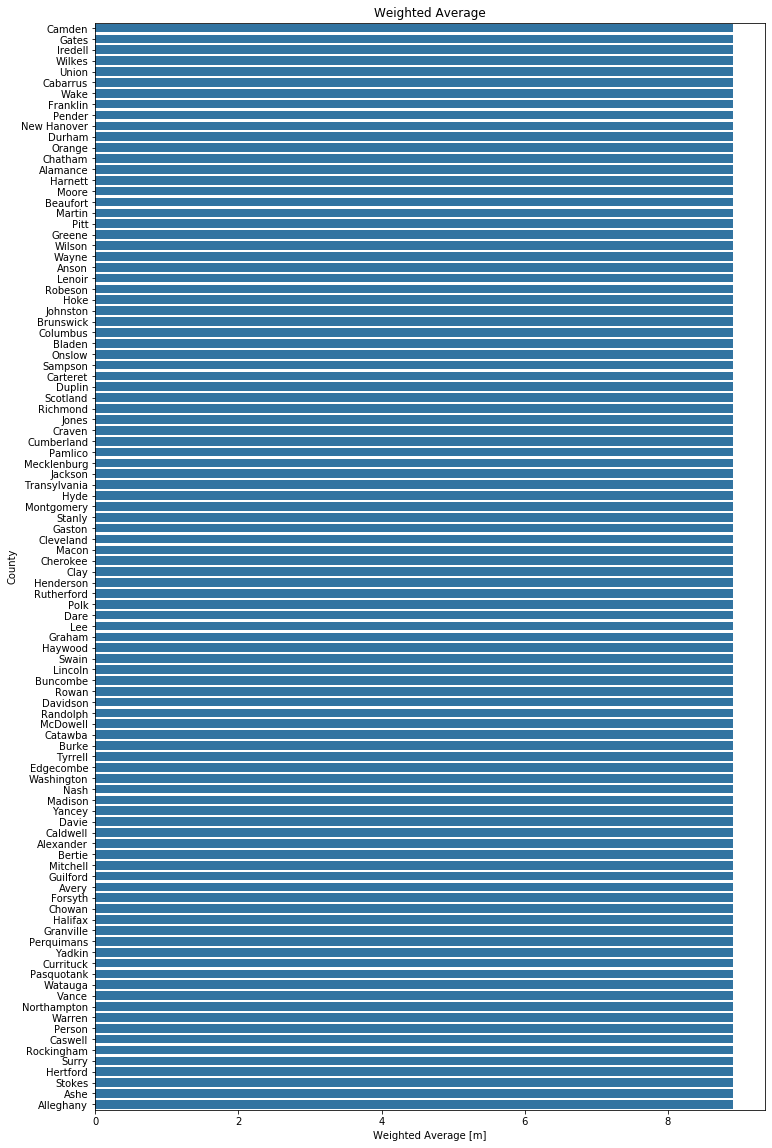

In [20]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 20))
ax=sns.barplot(data=results_df,x='Weighted Average',y='County',color='tab:blue')
ax.set_title('Weighted Average')
ax.set_xlabel('Weighted Average [m]')
plt.show()